# 观察训练过程中topsim_mid与泛化性关系（F-MNIST版本）发现个BUG！Learning Speed不该这么测，这里的ls应该是Bob fine tune的速度，不是新Alice学习该mapping的速度！回头一起补上

切换成Color-MNIST后，发现很多setting下，topsim_mid都会存在先上后下的情况，因此首先探究下这种行为意味着什么：
1. High topsim是否和High generalization ability有必然联系
2. Mid layer附近的non-lineartiy设计以及Loss设计会有影响么？
3. High topsim可否在NIL结构里不断突破“最高”，一代代增长

EXP1~3结论：
Sigmoid和Tanh的设计中，Topsim与gen ability正相关，与learning speed相关，即对应这“topsim高的就好学，就好泛化”，而在original setting中，topsim的趋势与之相反。不过在三组试验中，**learning speed和gen ability都是正相关的**，这个结论比较合理。

此外，注意到Sigmoid和original setting的gen ability (即valid acc)都能达到0.55+，而tanh setting下只有0.4+，因此ReLU+tanh在本task上似乎并不是一个特别好的设计。

接下来考虑换用F-MNIST，重复同样的实验，看看是否有一样的结论。

In [1]:
from MNIST_standard_classification import *
import seaborn as sns
import pandas as pd

PRE_ROUNDS = 10
INT_ROUNDS = 10
FIN_ROUNDS = 4
    

## Experiment 1： Sigmoid Setting of LeNet
### Network Strucutre：
**采用略有经修改的LeNet结构，取经过2层CNN+MaxPool，然后去掉ReLU，改为Sigmoid（1*400）为mid，mid后边接两层Linear+ReLU。计算(x,mid)的topsim时，由于希望mid中的元素都接近0/1，我们用hamming距离计算。**
### 实验流程：

- Case 1：观察随机初始化的agent，在进行Bob train + Fine tune后得到的泛化性能
- Case 2：观察你supervised learning过程中，各阶段agent的泛化性能：
    - Step 1：跑一遍pop_interact_clas，期间记记录下各个时间点的agent
    - Step 2：每一个agent都拿去跑一下pop_interact_Bob_fine

### 载入数据，观察下interact phase的各种指标情况

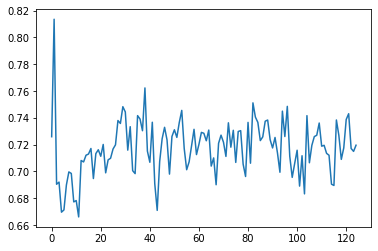

In [2]:
gen_ability_interact = np.load('results/sigmoid_mid/gen_results_inter.npy',allow_pickle=True)
gen_ability_interact = gen_ability_interact.item()

plt.plot(gen_ability_interact['topsim_mid'])

See the correlation between topsim_mid and generalization ability

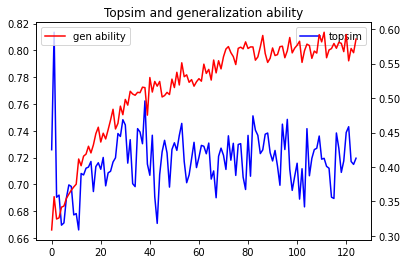

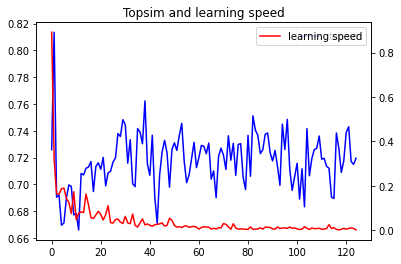

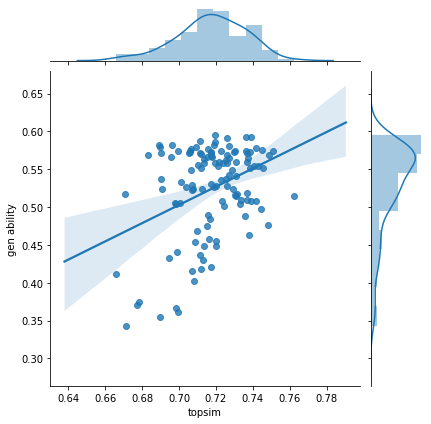

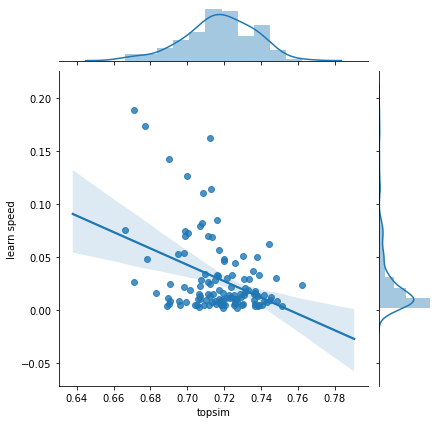

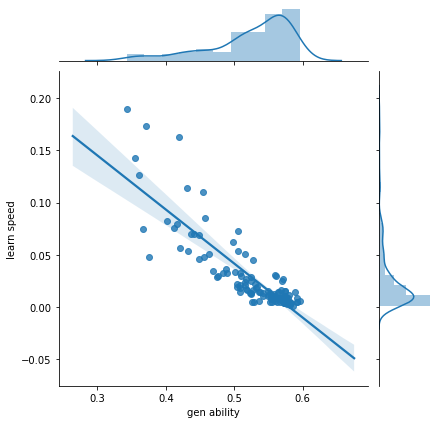

In [3]:
N_SNAPS = len(gen_ability_interact['topsim_mid'])
L_V_ACC = len(gen_ability_interact['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_interact[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_interact[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_interact['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()

# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_interact['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()


# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_interact['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')


### 载入数据，观察下pre-train phase的各种指标情况

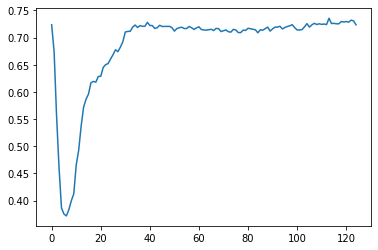

In [4]:
gen_ability_pre = np.load('results/sigmoid_mid/gen_results_pre.npy',allow_pickle=True)
gen_ability_pre = gen_ability_pre.item()
plt.plot(gen_ability_pre['topsim_mid'])

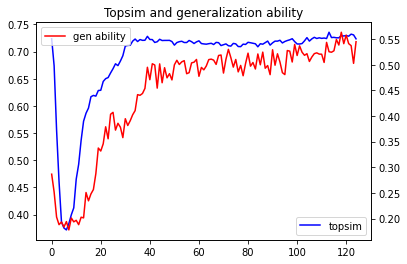

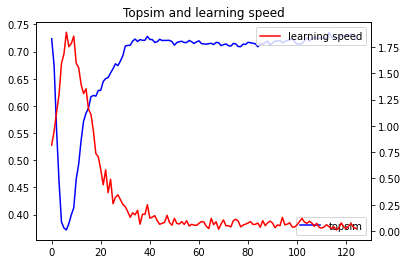

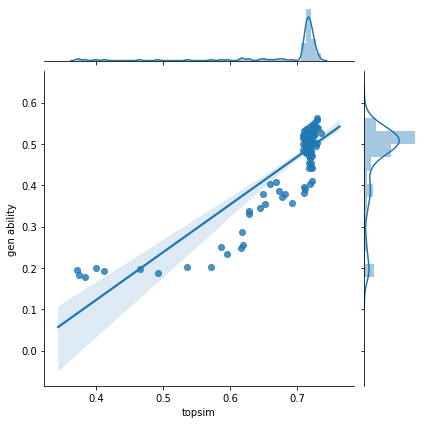

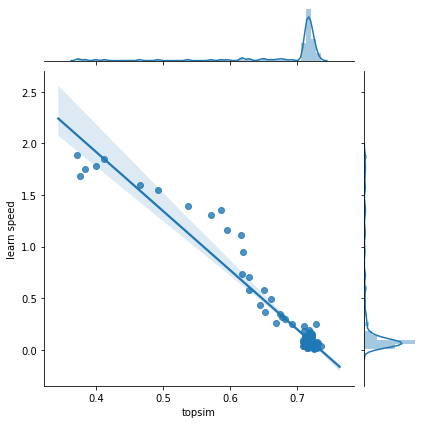

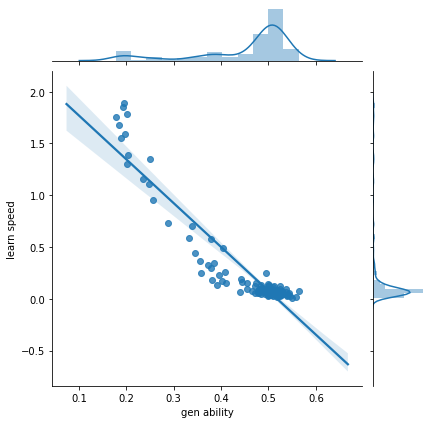

In [5]:
N_SNAPS = len(gen_ability_pre['topsim_mid'])
L_V_ACC = len(gen_ability_pre['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_pre[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_pre[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_pre['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()


# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_pre['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()

# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_pre['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')


## Experiment 2： Tanh Setting of LeNet
### Network Strucutre：
**采用略有修改的LeNet结构，取经过2层CNN+ReLU+MaxPool后的表示（注意是先ReLU！），由于经过ReLU后都是>0的数，所以后边加Tanh将其映射到[0,1]。之后（1*400）为mid，mid后边接两层Linear+ReLU。计算(x,mid)的topsim时，由于mid取值范围是实数，我们用cosine距离计算。**
### 实验流程：

- Case 1：观察随机初始化的agent，在进行Bob train + Fine tune后得到的泛化性能
- Case 2：观察你supervised learning过程中，各阶段agent的泛化性能：
    - Step 1：跑一遍pop_interact_clas，期间记记录下各个时间点的agent
    - Step 2：每一个agent都拿去跑一下pop_interact_Bob_fine

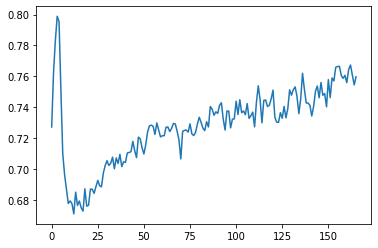

In [6]:
gen_ability_interact = np.load('results/tanh_mid/gen_results_inter.npy',allow_pickle=True)
gen_ability_interact = gen_ability_interact.item()
plt.plot(gen_ability_interact['topsim_mid'])

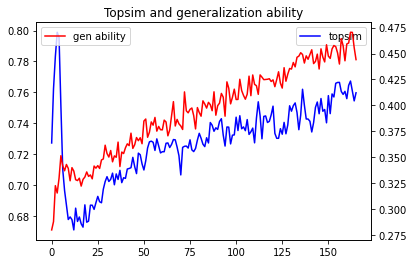

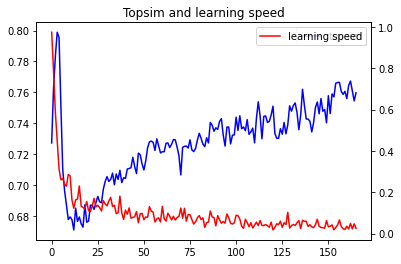

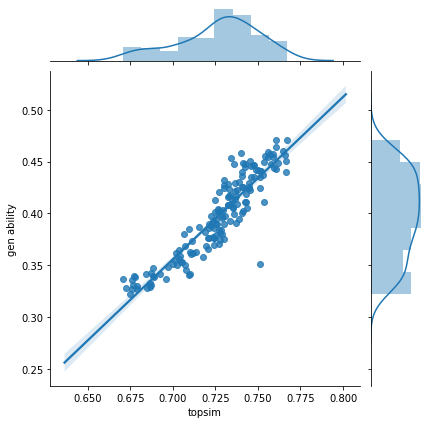

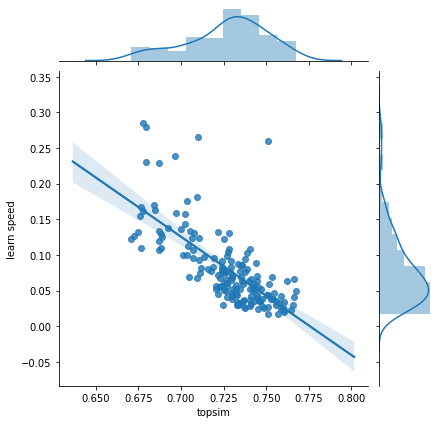

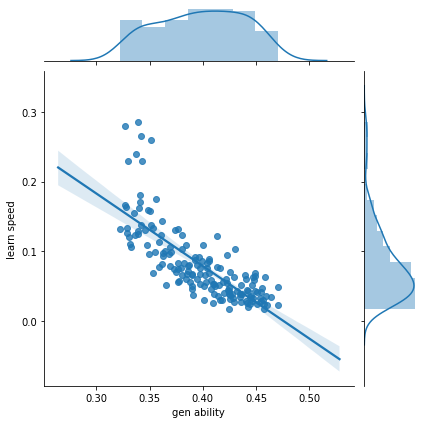

In [7]:
N_SNAPS = len(gen_ability_interact['topsim_mid'])
L_V_ACC = len(gen_ability_interact['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_interact[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_interact[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_interact['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()

# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_interact['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()


# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_interact['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')


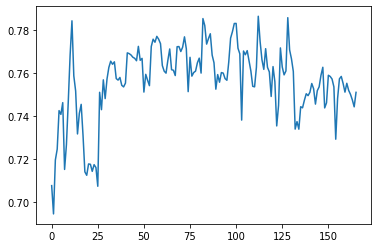

In [8]:
gen_ability_pre = np.load('results/tanh_mid/gen_results_pre.npy',allow_pickle=True)
gen_ability_pre = gen_ability_pre.item()
plt.plot(gen_ability_pre['topsim_mid'])

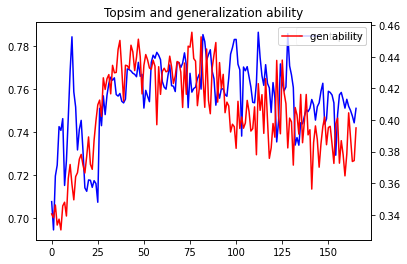

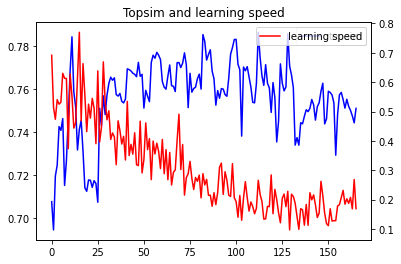

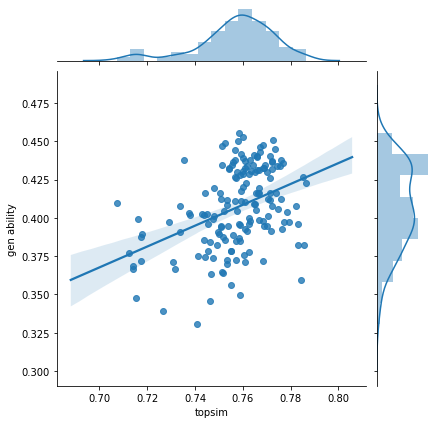

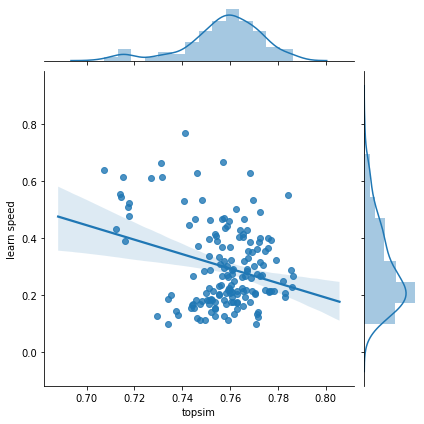

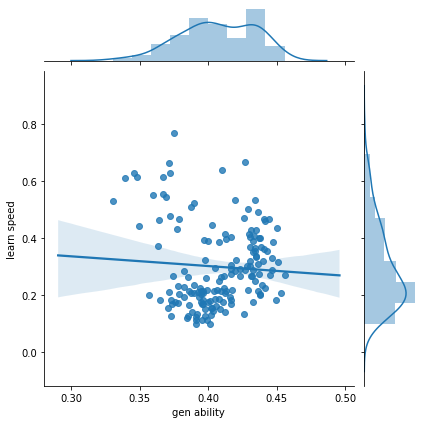

In [9]:
N_SNAPS = len(gen_ability_pre['topsim_mid'])
L_V_ACC = len(gen_ability_pre['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_pre[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_pre[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_pre['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()


# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_pre['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()

# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_pre['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')


## Experiment 3： Standard Setting of LeNet
### Network Strucutre：
**采用略有修改的LeNet结构，取经过2层CNN+ReLU+MaxPool后的表示（注意是先ReLU！）不用加任何squash的non-linearty[0,1]。之后（1*400）为mid，mid后边接两层Linear+ReLU。计算(x,mid)的topsim时，由于mid取值范围是实数，我们用cosine距离计算。**
### 实验流程：

- Case 1：观察随机初始化的agent，在进行Bob train + Fine tune后得到的泛化性能
- Case 2：观察你supervised learning过程中，各阶段agent的泛化性能：
    - Step 1：跑一遍pop_interact_clas，期间记记录下各个时间点的agent
    - Step 2：每一个agent都拿去跑一下pop_interact_Bob_fine

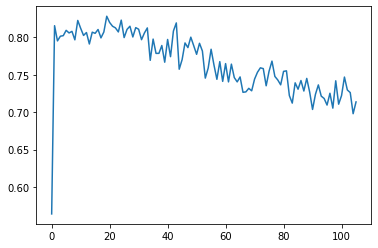

In [2]:
gen_ability_interact = np.load('results/F_origin_setting/gen_results_inter.npy',allow_pickle=True)
gen_ability_interact = gen_ability_interact.item()
plt.plot(gen_ability_interact['topsim_mid'])

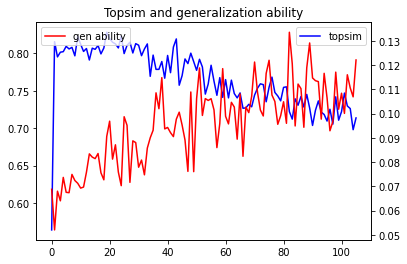

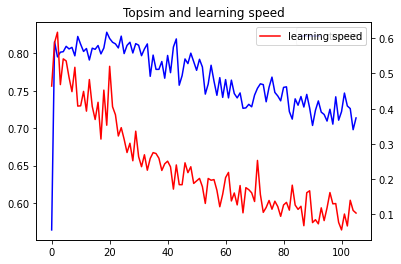

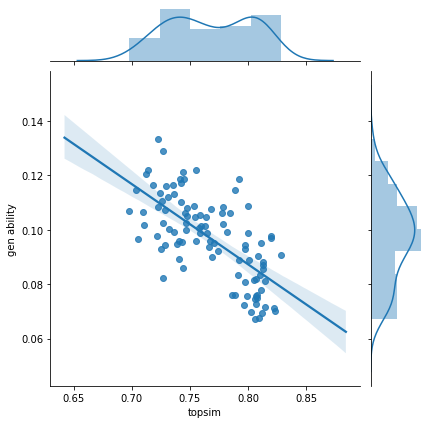

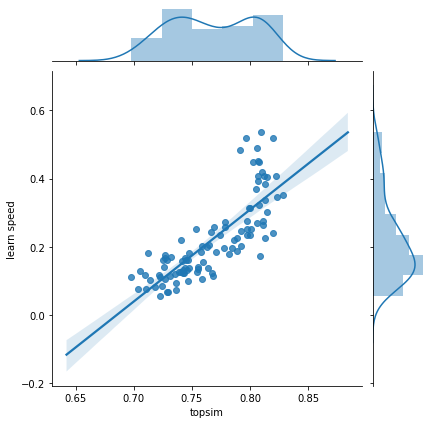

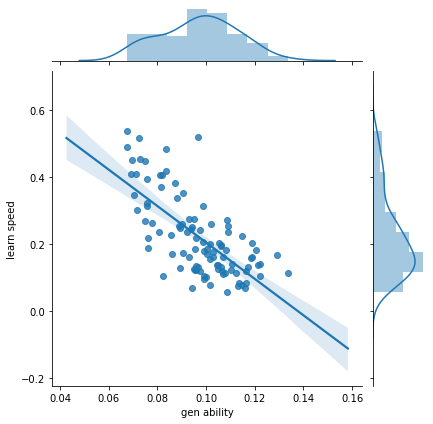

In [3]:
N_SNAPS = len(gen_ability_interact['topsim_mid'])
L_V_ACC = len(gen_ability_interact['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_interact[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_interact[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_interact['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()

# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_interact['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()


# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_interact['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')


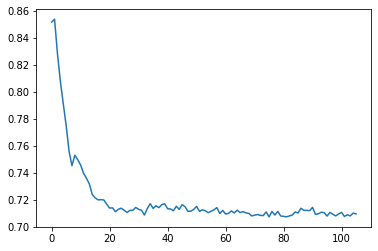

In [4]:
gen_ability_pre = np.load('results/F_origin_setting/gen_results_pre.npy',allow_pickle=True)
gen_ability_pre = gen_ability_pre.item()
plt.plot(gen_ability_pre['topsim_mid'])

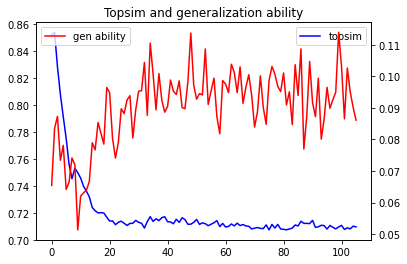

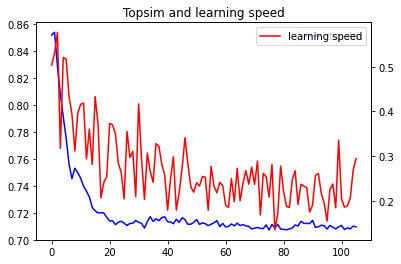

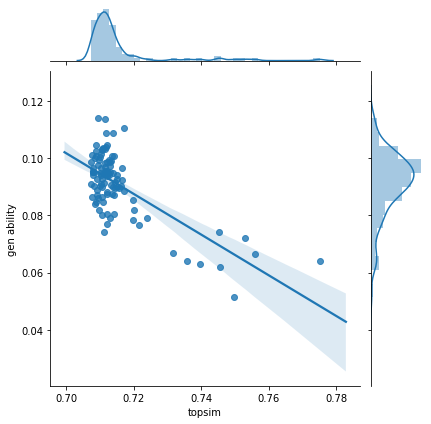

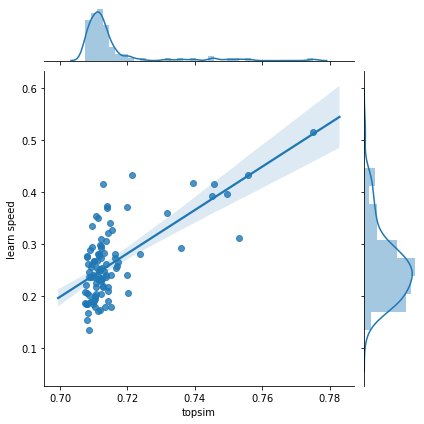

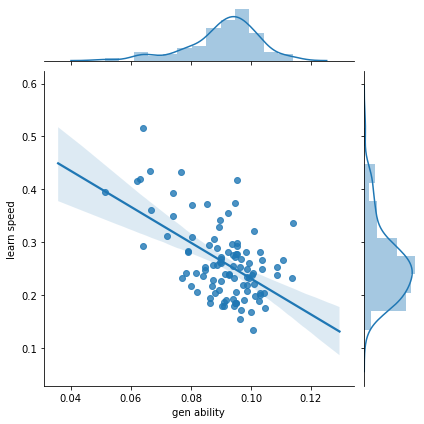

In [5]:
N_SNAPS = len(gen_ability_pre['topsim_mid'])
L_V_ACC = len(gen_ability_pre['v_acc_0'])
OB_KEY = 'v_acc_'
LS_KEY = 't_loss_'
val_acc_list = []
learn_spd_list = []
for i in range(N_SNAPS):
    idx = i
    key_name1 = OB_KEY+str(idx)
    key_name2 = LS_KEY+str(idx)
    val_acc_list.append(np.mean(gen_ability_pre[key_name1][-5:]))
    learn_spd_list.append(np.sum(gen_ability_pre[key_name2][-5:]))


# ========= Figure 1: line chart of topsim and gen ability ===========
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(gen_ability_pre['topsim_mid'],color='b',label='topsim')
ax2.plot(val_acc_list,color='r',label='gen ability')
ax1.legend()
ax2.legend()
plt.title('Topsim and generalization ability')
plt.show()


# ========= Figure 2: line chart of topsim and learning speed ===========
fig3, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.plot(gen_ability_pre['topsim_mid'], color='b',label='topsim')
ax4.plot(learn_spd_list,color='r',label='learning speed')
ax3.legend()
ax4.legend()
plt.title('Topsim and learning speed')
plt.show()

# ========= Figure 345: scatter chart of topsim and gen ability ========
arr_topsim = np.asarray(gen_ability_pre['topsim_mid']).reshape(-1,1)
arr_gen_abi = np.asarray(val_acc_list).reshape(-1,1)
arr_learn_speed = np.asarray(learn_spd_list).reshape(-1,1)

data_df = pd.DataFrame(np.concatenate((arr_topsim[5:],arr_gen_abi[5:],arr_learn_speed[5:]),1),
                             columns=['topsim','gen ability','learn speed'])

sns.jointplot(x='topsim', y='gen ability', data=data_df, kind='reg')
sns.jointplot(x='topsim', y='learn speed', data=data_df, kind='reg')
sns.jointplot(x='gen ability', y='learn speed', data=data_df, kind='reg')
